<h3>NLP Feature Engineering</h3>

I have streamlined the analysis with the NLP pipeline included in `NLP.py`. By creating an `NLModeler`, I can read in unstructured text, apply preprocessing, create a dictionary and a full corpus, and utilize tf-idf and topic modeling. The features calculated from these models will be explored, and combined with those already included in the `articles` and `sentences` tables in the `medium` database, and combined into a useful model.

<b>Goals:</b>
<ol>
<li>Read in `articles` and `sentences` dbs.</li>
<li>Use an NLModeler to create chained tf-idf and lsa models.</li>
<li>Calculate the mean tf-idf per sentence.</li>
<li>Plot the distribution of stfidf by highlight label.</li>
<li>Plot a scatter of stfidf versus other potential features.</li>
<li>Calculate the similarity in LSA space of each sentence to its own article.</li>
</ol>

In [1]:
# import libraries

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import NLP
from matplotlib import pyplot as plt
import random
import math
from sklearn import linear_model, metrics, ensemble
import pickle

<h4>1. Read in articles and sentences dbs.</h4>

In [2]:
# connect to postgresql db
username = 'kimberly'
dbname = 'medium'

dbe = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [3]:
# get articles df, drop missing data
dfA = pd.read_sql('articles', dbe, index_col='postid')
dfA = dfA.dropna(axis=0,how='any')
#print(dfA.shape)
#dfA.head()

In [4]:
# get sentences df
dfS = pd.read_sql('sentences', dbe, index_col='level_0')
#print(dfS.shape)
#dfS.head()

In [13]:
pkl_file = open('sentence_lsa.pkl', 'rb')
dfLsa = pickle.load(pkl_file)
pkl_file.close()  
    
# for ax,pid in enumerate(dfA.index):
#     if ax<1:
# #        print(ax)
# #        print(pid)
# #        print(len(dfS.postid==pid))
# #        print(dfS.postid==pid)
#         print(dfLsa.loc[dfS.postid==pid])

In [22]:
#dfSt = dfS.iloc[0:10]
#dfLt = dfLsa[0][0]
#print(dfSt)
#print(len(dfLt))
2.5*434792/60/60

301.93888888888887

<h4>2. Use an NLModeler to create chained tf-idf and lsa models.</h4>

In [5]:
mText = NLP.NLModeler(list(dfA.text))
#print(mText)

In [6]:
mText.process_text(break_on=['.'], init_split_on='database', origdb=list(dfA.origdb))
#dfP = mText.get_text(ttype='tokenized',output_type='dataframe')
#print(dfP.shape)
#dfP.head()
#dfP = []

In [7]:
mText.make_dictionary()
mText.load_corpus('alldoc_corpus.mm')
mText.make_ddiv_corpus()
mText.make_tfidf()
mText.make_lsa()
mscorp = mText.ddiv_corpus
mtfidf = mText.tfidf

Now, we test the ability to load a new vector (`"new sentence"`), process it with the `quick_input` option, and represent it native BOW space and in tfidf space.

In [1]:
#new_vec = NLP.NLProcessor(['new sentence'],quick_input=True)
#new_vec.process_text(break_on=['.'],init_split_on=None)
#new_vec.flatten_text()
#ntext = new_vec.get_text(ttype='flat')
#mdict = mText.get_dictionary()
#print(ntext[0])
#print(mdict.doc2bow(ntext[0]))
#print(mtfidf[mdict.doc2bow(ntext[0])])

<b>3. Calculate the mean tf-idf per sentence.</b>

In [12]:
sentence_tfidf = mtfidf[mscorp]
stfidf = []
for sent_rep in sentence_tfidf:
    stfidf.append( np.mean([wr[1] for wr in sent_rep]) )
print(len(stfidf))
print(stfidf[0])

/Users/kimberly/anaconda3/envs/insight_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kimberly/anaconda3/envs/insight_env/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


434792
0.707063742336


In [13]:
print(stfidf[0])

0.707063742336


In [12]:
# add stfidf to dfS
dfS['stfidf'] = stfidf
#dfS.head()

In [13]:
# save stfidf in a pickle
import pickle
output = open('stfidf.pkl', 'wb')
pickle.dump(stfidf, output)
output.close()

In [10]:
# calculate MAX tfidf
sentence_tfidf = mtfidf[mscorp]
maxtfidf = []
for sent_rep in sentence_tfidf:
    try:
        maxtfidf.append( np.max([wr[1] for wr in sent_rep]) )
    except:
        maxtfidf.append( None )
print(len(maxtfidf))
print(maxtfidf[0])

434792
0.71486529822


In [14]:
# save maxtfidf in a pickle
import pickle
with open('maxtfidf.pkl', 'wb') as output:
    pickle.dump(maxtfidf, output)


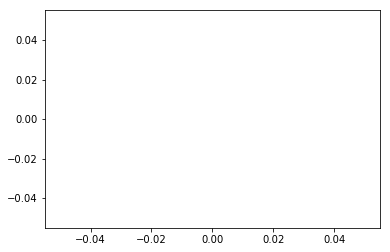

In [16]:
plt.figure();
plt.plot(x=stfidf,y=maxtfidf,color='red')
plt.show()

<b>4. Plot the distribution of tf-idf by sentence label.</b>

In [2]:
# histogram of tf-idf by label
#plt.figure();
#dfS['stfidf'].hist(by=dfS.slabel, bins=50)
#plt.show()


There is not really any difference here. What about LSA self-article similarity?

<b>5. Calculate the similarity in LSA space of each sentence to its own article.</b>

In [13]:
# get LSA model and LSA sentence corpus
lsa = mText.lsa



In [14]:
sentence_lsa = lsa[sentence_tfidf]


In [16]:
# save sentence_lsa in a pickle
import pickle
output = open('sentence_lsa.pkl', 'wb')
pickle.dump(sentence_lsa, output)
output.close()

In [20]:
lsa.print_topics(5)

[(0,
  '0.098*"design" + 0.082*"life" + 0.079*"book" + 0.077*"user" + 0.075*"product" + 0.074*"compani" + 0.070*"learn" + 0.068*"success" + 0.066*"app" + 0.065*"busi"'),
 (1,
  '-0.322*"user" + -0.306*"design" + 0.237*"trump" + -0.219*"app" + -0.138*"ux" + -0.114*"code" + -0.104*"ui" + 0.101*"women" + 0.096*"presid" + -0.095*"product"'),
 (2,
  '0.407*"trump" + 0.165*"user" + 0.150*"clinton" + 0.150*"presid" + 0.143*"vote" + 0.134*"elect" + 0.132*"hillari" + 0.117*"design" + -0.111*"book" + 0.109*"women"'),
 (3,
  '0.575*"que" + 0.395*"de" + 0.253*"não" + 0.230*"é" + 0.217*"e" + 0.149*"da" + 0.148*"um" + 0.143*"uma" + 0.140*"para" + 0.121*"se"'),
 (4,
  '0.275*"creatom" + 0.238*"jon" + 0.177*"startup" + 0.174*"compani" + 0.168*"agenc" + -0.138*"habit" + 0.127*"market" + 0.127*"gl" + 0.127*"goo" + 0.123*"westenberg"')]

In [21]:
# calculate similarity of each sentence to own article

# we set up for similarity queries 
corpus_lsa = mText.get_corpus(ctype='lsa')
from gensim import similarities
sim_index = similarities.Similarity('.',corpus_lsa,num_features = 200)

In [22]:
def sentence_own_sim(sent_reps,index,docpos):
    '''finds similarity of ddivs (ddiv_list is list fo sents with same doc) to own doc'''
    sims = index[list(sent_reps)]
    sims = [s[docpos] for s in sims]
    return sims

I have now outsourced this to calculate_lsa_sims.py. Pivoting to downsampling...

<b>Balancing Data.</b>

<b>First try</b>: randomly choosing a number of False examples that is 3 times the number of True examples.

In [5]:
print(dfS.shape)
dfS.head()

(434792, 7)


,alength,index,postid,sentence,slabel,sposition,swcount
level_0,,,,,,,
0,52,0.0,1015a0f4961d,"{hola,desde,cuba}",False,0,3
1,52,0.0,1015a0f4961d,"{today,air,force,one,touched,havana,first,time...",True,1,9
2,52,0.0,1015a0f4961d,"{question,remarkable,moment,relationship,unite...",False,2,9
3,52,0.0,1015a0f4961d,"{also,landmark,progress,made,since,president,o...",False,3,29
4,52,0.0,1015a0f4961d,"{trip,also,professionally,personally,meaningfu...",False,4,19


In [6]:
434792-4640

430152

In [278]:
dfS_True = dfS[dfS.slabel==True]
dfS_False = dfS[dfS.slabel==False]
print(dfS_True.shape)
print(dfS_False.shape)

(5920, 8)
(428872, 8)


In [279]:
number_false = dfS_True.shape[0]
print(number_false)

5920


In [280]:
false_indices = np.random.choice(dfS_False.shape[0], number_false, replace=False)

#pkl_file = open('false_indices.pkl', 'rb')
#false_indices = pickle.load(pkl_file)
#pkl_file.close()

In [281]:
print(false_indices[0:10])

[365707 207130 155617 101374 322864  74705   8258  61529 216591 242845]


In [282]:
output = open('false_indices_exactbal.pkl', 'wb')
pickle.dump(false_indices, output)
output.close()

In [283]:
dfS_False_dsamp = dfS_False.iloc[false_indices]

In [284]:
dfS_True = dfS_True.drop(dfS_True[dfS_True.stfidf.isnull()].index)
dfS_False_dsamp = dfS_False_dsamp.drop(dfS_False_dsamp[dfS_False_dsamp.stfidf.isnull()].index)

In [285]:
dfS_True['scalepos'] = dfS_True['sposition']/dfS_True['alength']
dfS_False_dsamp['scalepos'] = dfS_False_dsamp['sposition']/dfS_False_dsamp['alength']

<b>Now train a model with this...</b>

In [286]:
# split training and test 80/20
true_train_indices = np.random.choice(dfS_True.shape[0], 
                                      math.floor(dfS_True.shape[0]*0.8), replace=False)
false_train_indices = np.random.choice(dfS_False_dsamp.shape[0], 
                                       math.floor(dfS_False_dsamp.shape[0]*0.8), replace=False)
dfS_True_train = dfS_True.iloc[true_train_indices]
dfS_False_dsamp_train = dfS_False_dsamp.iloc[false_train_indices]
dfTrain_balanced = pd.concat([dfS_True_train,dfS_False_dsamp_train])
print(dfS_True_train.shape)
print(dfS_False_dsamp_train.shape)
print(dfTrain_balanced.shape)

true_test_indices = [x for x in range(dfS_True.shape[0]) if x not in true_train_indices]
false_test_indices = [x for x in range(dfS_False_dsamp.shape[0]) if x not in false_train_indices]
dfS_True_test = dfS_True.iloc[true_test_indices]
dfS_False_dsamp_test = dfS_False_dsamp.iloc[false_test_indices]
dfTest_balanced = pd.concat([dfS_True_test,dfS_False_dsamp_test])
print(dfS_True_test.shape)
print(dfS_False_dsamp_test.shape)
print(dfTest_balanced.shape)

(4670, 9)
(4673, 9)
(9343, 9)
(1168, 9)
(1169, 9)
(2337, 9)


In [287]:
Ytrain = dfTrain_balanced['slabel'].astype('int')
Xtrain = dfTrain_balanced[['sposition','swcount','stfidf','alength']]
#Xtrain = dfTrain_balanced[['scalepos','swcount','stfidf']]
Ytest = dfTest_balanced['slabel'].astype('int')
#Xtest = dfTest_balanced[['scalepos','swcount','stfidf']]
Xtest = dfTest_balanced[['sposition','swcount','stfidf','alength']]


In [247]:
lrm = linear_model.LogisticRegression(class_weight={1: 0.25, 0: 0.75})
lrm.fit(Xtrain,Ytrain)

LogisticRegression(C=1.0, class_weight={1: 0.25, 0: 0.75}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [248]:
# test on the 2/3 of training set
print(lrm.score(Xtrain,Ytrain), 1 - Ytrain.mean())

# test on the other 1/3 of X, y
print(lrm.score(Xtest,Ytest), 1 - Ytest.mean())

0.749920458161 0.749920458161
0.749682337992 0.749682337992


In [226]:
lrm.predict(Xtrain).any()
lrm.predict(Xtest).any()

False

Try a random forest...

In [288]:
rfm = ensemble.RandomForestClassifier(n_estimators=500, class_weight=None)
rfm.fit(Xtrain,Ytrain)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [289]:
print(rfm.score(Xtrain,Ytrain))
print(rfm.score(Xtest,Ytest))

0.999892967997
0.616602481814


In [307]:
rfm.predict_proba(Xtrain)
test_predix = rfm.predict_proba(Xtest)[:,1]
test_predix = pd.DataFrame(test_predix,Ytest,columns=['pred'])
test_predix.head()

,pred
slabel,
1,0.512
1,0.380
1,0.694
1,0.678
1,0.512


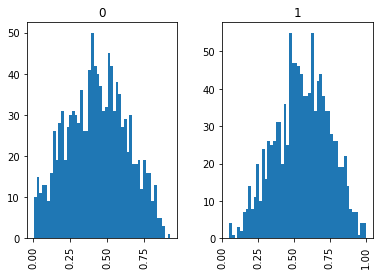

In [312]:
plt.figure();
test_predix.hist(by=test_predix.index,bins=50)
plt.show()

<b>Descope: Try only articles tagged as most common tag.</b>

What is most common tag?

In [158]:
all_tags = []
for art in range(dfA.shape[0]):
    all_tags.append(dfA.tags[art])

all_tags = ','.join(all_tags).split(',')
    
 

In [186]:
dfTags = pd.DataFrame(all_tags)
dfTags.columns = [['tag']]


sizes = dfTags.groupby(['tag']).size()
sizes.index[sizes>700]

Index(['Entrepreneurship', 'Life', 'Life Lessons', 'Startup'], dtype='object', name='tag')

choose <b>Startup</b>

In [191]:

stA = dfA[dfA.tags.str.contains('Startup')]

In [192]:
stA.shape

(986, 13)

In [193]:
stS = pd.merge(dfS, stA, how='left', left_on='postid',
         left_index=False, right_index=True)


In [196]:
print(stS.shape)
stS.drop(stS[stS.title.isnull()].index,inplace=True)

(434792, 21)


In [197]:
print(stS.shape)

(95631, 21)


In [199]:
stS.groupby('postid').size()

postid
101a407e8c61     65
104b53107e8b     80
1057e6c6d2b       9
107a1624d96b    153
10e547b2c67f     85
11422270e1e4     47
11a8b8a52b5f    245
1214d572044      50
121c705fb2ff     58
12214a0ab057     71
122bdadf5775     43
12d900979cf2     65
14271441b702    205
143d43ee3742    109
145ede63eb12     40
1487e1943347     85
15432c74fb51    112
156dae82ed2c    108
15c3724038b4    169
1605bcdbeafc    103
161e833316ec     61
164b77bd04b8     41
16583e464dc6     34
16731841aaf4     64
167a824c3bb5     83
16e1a26fe9ba     36
16e8cfbc127b    110
1737d0bcba7a    124
173d08e1cc40     26
175ce38619c7     51
               ... 
f7de6e84dcee    110
f800b408926e     71
f84c3f99b3c5    192
f8926a3134df     19
f8efc4840861    114
f923c8d8a4be     25
f93d5a3b1309    108
f96539729c5d     17
f972b27d3273    243
f98560b1a3c7     20
f986b2c77294    151
f9d77125a515     55
fa7a9e37ff97    107
fabc3ff95a2f     56
fb177866b713     45
fb2c2625f757     85
fb649c6b7f00    133
fb6fd5df3bde    177
fbd7d3a7600f 

In [200]:
stS.groupby('slabel').size()

slabel
False    94637
True       994
dtype: int64

<b>Okay, try now.</b>
<ol>
<li>Downsample</li>
<li>Try logistic</li>
<li>run lsa</li>
</ol>

In [202]:
dfS_True = stS[stS.slabel==True]
dfS_False = stS[stS.slabel==False]
print(dfS_True.shape)
print(dfS_False.shape)

(994, 21)
(94637, 21)
